Test loss: 0.0424361377954483
Test accuracy: 0.9865999817848206


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Train Accuracy: 1.0
Test Accuracy:  0.9982


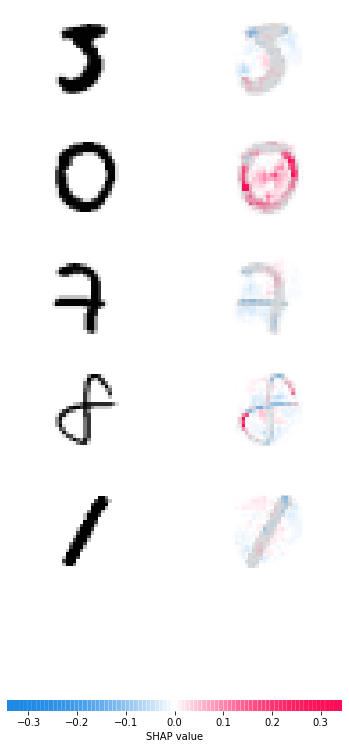

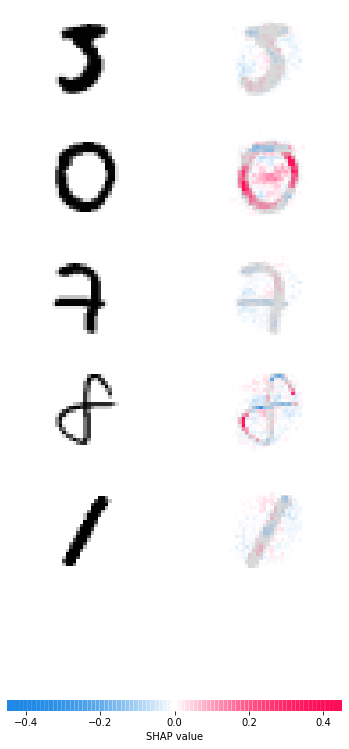

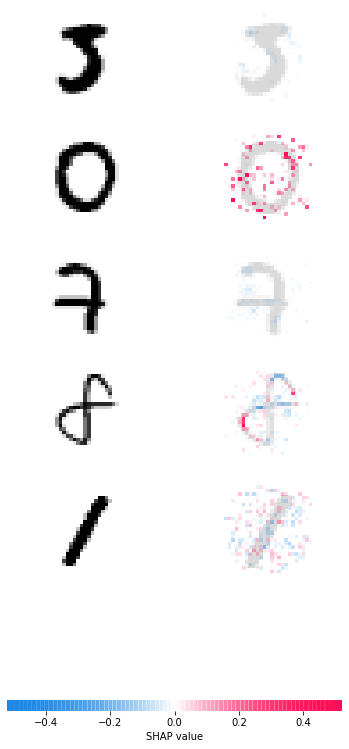

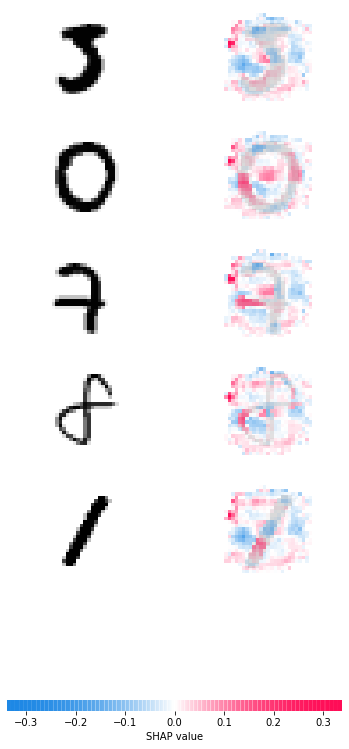

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from time import time
import matplotlib
import pickle
import sys
import os

# Import local version of shap
sys.path.insert(0, "/homes/gws/hughchen/per_ref_shap/shap")
import shap

from deepshap.explanation import lime_wrapper, stacked_shap_nn_tree
from deepshap.evaluation import ablate
from deepshap.data import load_mnist
from model import mnist_cnn_xgb

IS_PLOT = False

# Get stacked model trained to predict zeros
binary_ind = 0
model = mnist_cnn_xgb(binary_ind=binary_ind)

# Load the data
x_train, y_train, x_test, y_test = load_mnist(binary_ind=binary_ind)

# Set explicand and reference
num_iter = 20
np.random.seed(1920)
seeds = np.random.choice(np.arange(10000),num_iter,replace=False)

runtime_lst = []
pos_ablated_preds_lst = []
neg_ablated_preds_lst = []

for seed in seeds:
    ######################################
    ### Select explicand and reference ###
    ######################################
    np.random.seed(seed)
    # explicand_inds = [0, 1, 2, 5, 21]
    explicand_inds = np.random.choice(np.arange(x_train.shape[0]),5,replace=False)
    while y_train[explicand_inds].sum() == 0:
        explicand_inds = np.random.choice(np.arange(x_train.shape[0]),5,replace=False)
    reference_inds = np.random.choice(np.arange(x_train.shape[0]),100,replace=False)
    explicand = x_train[explicand_inds]
    reference = x_train[reference_inds]

    def model_pred_flat(x): return(model.predict(x.reshape([x.shape[0], 28, 28, 1])))
    explicand_flat = explicand.reshape([5,28*28])
    reference_flat = reference.reshape([reference.shape[0],28*28])
    
    ####################
    ### Attributions ###
    ####################
    def save_attr(path, explanation_fn, mod, expli, refer, nsamp=10000):
        """
        Save the attributions from each seed
        """

        pre, post = path.split(".")
        runtime_path = "{}_runtime.{}".format(pre,post)
        if not os.path.exists(path) or not os.path.exists(runtime_path):
            start = time()

            if "shap_values" in dir(explanation_fn): 
                # SHAP Package (Kernel and Sampling)
                explainer = explanation_fn(mod, refer)
                attr      = explainer.shap_values(expli, num_samples=nsamp)
            elif "__name__" in dir(explanation_fn) and explanation_fn.__name__ == "lime_wrapper":
                # LIME
                attr      = explanation_fn(mod, expli, refer, mode="regression", 
                                           wrap_pred=False, num_samples=nsamp)
            else:
                # Stacked SHAP
                attr      = explanation_fn(mod, expli, refer)

            runtime = time() - start

            np.save(path, attr)             # Save the attributions
            np.save(runtime_path, runtime)  # Save the runtime
        else:
            # Load the attribution and the runtime
            attr = np.load(path)
            runtime = np.load(runtime_path)

        return(attr, runtime)

    attr_seed_path = "attr/seed_{}/".format(seed)
    if not os.path.exists(attr_seed_path): os.makedirs(attr_seed_path)

    ### DeepSHAP attributions ###
    attr_path = attr_seed_path+"se_attr.npy"
    se_attr, se_runtime = save_attr(attr_path, stacked_shap_nn_tree, model, explicand, reference)
    if IS_PLOT or seed == seeds[0]: 
        shap.image_plot(se_attr, -explicand, show=False)
        plt.savefig("fig/stacked_mnist.pdf")

    ### Sampling explainer ###
    attr_path = attr_seed_path+"sa_attr.npy"
    sa_attr, sa_runtime = save_attr(attr_path, shap.SamplingExplainer, model_pred_flat, 
                                    explicand_flat, reference_flat, nsamp=100000)
    if IS_PLOT or seed == seeds[0]: 
        shap.image_plot(sa_attr.reshape([5,28,28,1]), -explicand, show=False)
        plt.savefig("fig/sample_mnist.pdf")

    ### Kernel explainer ###
    attr_path = attr_seed_path+"ke_attr.npy"
    ke_attr, ke_runtime = save_attr(attr_path, shap.KernelExplainer, model_pred_flat, 
                                    explicand_flat, reference_flat, nsamp=100000)
    if IS_PLOT or seed == seeds[0]: 
        shap.image_plot(ke_attr.reshape([5,28,28,1]), -explicand, show=False)
        plt.savefig("fig/kernel_mnist.pdf")

    ### LIME ###
    attr_path = attr_seed_path+"li_attr.npy"
    li_attr, li_runtime = save_attr(attr_path, lime_wrapper, model_pred_flat, 
                                    explicand_flat, reference_flat, nsamp=100000)
    if IS_PLOT or seed == seeds[0]: 
        shap.image_plot(li_attr.reshape([5,28,28,1]), -explicand, show=False)
        plt.savefig("fig/lime_mnist.pdf")

    ################
    ### Runtimes ###
    ################
    runtimes = [se_runtime, sa_runtime, ke_runtime, li_runtime]
    runtime_lst.append(runtimes)
    if IS_PLOT: 
        plt.clf()
        matplotlib.rcParams['figure.figsize'] = 4, 4
        plt.bar(range(4), runtimes)
        plt.xticks(range(4),["DeepSHAP", "IME", "KernelSHAP", "LIME"])
        plt.title("Runtime")
        plt.show()

    ############################
    ### Get ablation results ###
    ############################
    refer_flat   = np.tile(reference_flat.mean(0)[None,:],[5,1])
    se_attr_flat = se_attr.reshape([5,28*28])

    results_seed_path = "results/seed_{}/".format(seed)
    if not os.path.exists(results_seed_path): os.makedirs(results_seed_path)

    def save_ablation(path, impute):

        if not os.path.exists(path):
            se_ablated_preds = ablate(model_pred_flat, se_attr_flat, explicand_flat, refer=refer_flat, impute=impute)
            sa_ablated_preds = ablate(model_pred_flat, sa_attr, explicand_flat, refer=refer_flat, impute=impute)
            ke_ablated_preds = ablate(model_pred_flat, ke_attr, explicand_flat, refer=refer_flat, impute=impute)
            li_ablated_preds = ablate(model_pred_flat, li_attr, explicand_flat, refer=refer_flat, impute=impute)
            ablated_preds = {"se":se_ablated_preds, "sa":sa_ablated_preds,
                             "ke":ke_ablated_preds, "li":li_ablated_preds}
            pickle.dump(ablated_preds, open(path,"wb"))
        else:
            ablated_preds = pickle.load(open(path,"rb"))
            se_ablated_preds = ablated_preds["se"]
            sa_ablated_preds = ablated_preds["sa"]
            ke_ablated_preds = ablated_preds["ke"]
            li_ablated_preds = ablated_preds["li"]

        return(se_ablated_preds, sa_ablated_preds, ke_ablated_preds, li_ablated_preds)

    def save_ablation_fig(impute):
        matplotlib.rcParams['figure.figsize'] = 4, 4
        plt.plot(se_ablated_preds, label="DeepSHAP")
        plt.plot(sa_ablated_preds, label="IME")
        plt.plot(ke_ablated_preds, label="Kernel")
        plt.plot(li_ablated_preds, label="LIME")
        plt.legend()
        plt.ylabel("Mean model prediction")
        plt.ylabel("Mean model prediction")
        plt.xlabel("# features ablated")
        plt.tight_layout()
        if "pos" in impute:
            plt.title("Positive ablation by mean")
            plt.savefig(results_seed_path+"pos_ablation.pdf")
        else:
            plt.title("Negative ablation by mean")
            plt.savefig(results_seed_path+"neg_ablation.pdf")
        plt.show()

    ### Positive ablation ###
    pos_path = results_seed_path+"pos_ablated_preds.p"
    se_ablated_preds, sa_ablated_preds, ke_ablated_preds, li_ablated_preds = save_ablation(pos_path, "pos")
    pos_ablated_preds_lst.append([se_ablated_preds, sa_ablated_preds, ke_ablated_preds, li_ablated_preds])
    if IS_PLOT: save_ablation_fig("pos")
    
    ### Negative ablation ###
    neg_path = results_seed_path+"neg_ablated_preds.p"
    se_ablated_preds, sa_ablated_preds, ke_ablated_preds, li_ablated_preds = save_ablation(neg_path, "neg")
    neg_ablated_preds_lst.append([se_ablated_preds, sa_ablated_preds, ke_ablated_preds, li_ablated_preds])
    if IS_PLOT: save_ablation_fig("neg")

### Plotting code

In [3]:
runtimes = np.array(runtime_lst)

# Convert to array and subtract by initial mean model prediction (no ablation)
pos_ablated_preds = np.array(pos_ablated_preds_lst)
pos_ablated_preds = (pos_ablated_preds - pos_ablated_preds[:,:,0][:,:,None])

neg_ablated_preds = np.array(neg_ablated_preds_lst)
neg_ablated_preds = (neg_ablated_preds - neg_ablated_preds[:,:,0][:,:,None])

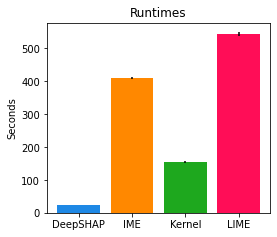

In [4]:
GREEN  = "#1ea81e"
BLUE   = "#1e88e5"
RED    = "#ff0d57"
ORANGE = "#ff8800"

matplotlib.rcParams['figure.figsize'] = 4, 3.5
plt.bar(range(0,4), runtimes.mean(0), yerr=1.96*runtimes.std(0)/np.sqrt(num_iter),
        color = [BLUE, ORANGE, GREEN, RED])
plt.xticks(range(0,4), ["DeepSHAP", "IME", "Kernel", "LIME"])
plt.title("Runtimes")
plt.ylabel("Seconds")
plt.savefig("fig/runtime.pdf")
plt.show()

78


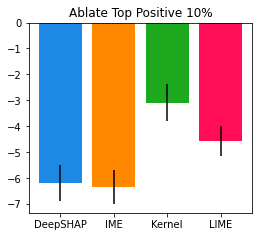

78


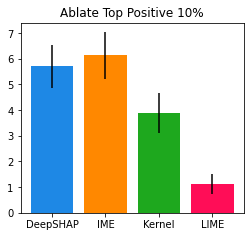

In [5]:
def ablate_top(percent, ablated_preds, impute):
    k = int(784*percent/100)
    print(k)
    topk_ablated_preds = ablated_preds[:,:,k]
    plt.bar(range(0,4), topk_ablated_preds.mean(0), 
            yerr=1.96*topk_ablated_preds.std(0)/np.sqrt(num_iter),
            color = [BLUE, ORANGE, GREEN, RED])
    plt.xticks(range(0,4), ["DeepSHAP", "IME", "Kernel", "LIME"])
    if impute == "pos":
        plt.title("Ablate Top Positive {}%".format(percent))
    else:
        plt.title("Ablate Top Negative {}%".format(percent))
    plt.savefig("fig/ablate_top_{}{}percent.pdf".format(impute,percent))
    plt.show()

ablate_top(10, pos_ablated_preds, "pos")
ablate_top(10, neg_ablated_preds, "neg")